In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Setting display preferences for output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#Reading NIMARKS project metadata spreadsheet
path_md = 'seusmbon_NOAA_MIMARKS_v1.0.8.survey.water.6.0_20240614.xlsx'
df_md = pd.read_excel(path_md, sheet_name='water_sample_data', skiprows=8)

In [4]:
#Reading cruise metadata measurements spreadsheet
path_ws = 'WSMasterSampleLog(Updated 4-25-24).xlsx'
df_ws = pd.read_excel(path_ws, sheet_name='All Depths')
df_ws['Station'] = [str(x) for x in df_ws.Station]

In [5]:
# Checking Metadata Depth Categorization #

In [6]:
df_md['depth_category'].value_counts()

depth_category
Surface           2644
Bottom             367
not applicable     104
MID                  9
0                    6
BLANK                3
Name: count, dtype: int64

In [7]:
#Filter to only 'Surface' or 'Bottom' samples
options = ['Surface', 'Bottom']
dfiltered_df_md = df_md[df_md['depth_category'].isin(options)].copy()
#Check the filtering
dfiltered_df_md['depth_category'].value_counts()

depth_category
Surface    2644
Bottom      367
Name: count, dtype: int64

In [8]:
# Aligning Cruise Metadata Depth Categorization to Match Metadata Depth Categorization #

In [9]:
#Filter to only eDNA stations (all C or CTD)
options = ['CTD', 'C']
cfiltered_df_ws = df_ws[df_ws['F or CTD'].isin(options)].copy()
#Check the filtering
cfiltered_df_ws['F or CTD'].value_counts()

F or CTD
C      4422
CTD     821
Name: count, dtype: int64

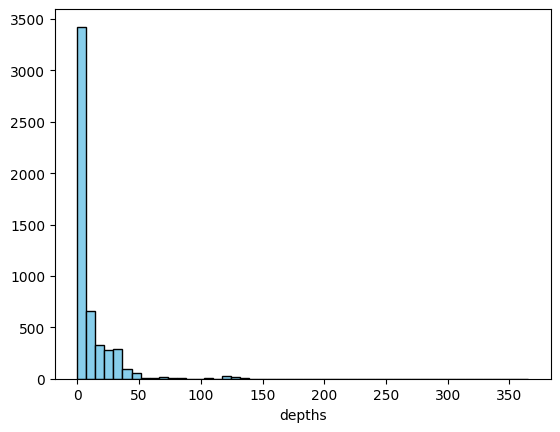

In [10]:
#Visually show the distribution of cruise depth measurements
plt.hist(cfiltered_df_ws['Depth'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('depths')
plt.show()

In [11]:
pd.Series(list(cfiltered_df_ws.columns))

0                                                  Rank
1                                              Keyfield
2                                                Cruise
3                                            Date (GMT)
4                                           Temperature
5                                              Salinity
6                                          Latitude Deg
7                                          Latitude Min
8                                      Latitude Decimal
9                                         Longitude Deg
10                                        Longitude Min
11                                    Longitude Decimal
12                                           Time (GMT)
13                                              Station
14                                             F or CTD
15                                                Depth
16                                   Chlorophyll Tube #
17                                     Avg chl a

In [12]:
#Creating a list to track indices of the dataframe
indices = cfiltered_df_ws.index.tolist()

#Creating a new list to add as a new column categorizing depths
depth_cat = []

#Iterating through to compare stations and categorize depths
n = 0
for i in range(len(indices) - 1):
    current_depth = cfiltered_df_ws.loc[indices[i], 'Depth']
    current_station = cfiltered_df_ws.loc[indices[i], 'Station']
    next_depth = cfiltered_df_ws.loc[indices[i + 1], 'Depth']
    next_station = cfiltered_df_ws.loc[indices[i + 1], 'Station']
    #Surface site
    if current_depth == 0:
        depth_cat.append("Surface")
        n = 0
    else:
        #Bottom site for a station with multiple measurements
        if current_station == next_station and next_depth != 0 and n == 0:
            depth_cat.append("Bottom")
            n = n + 1
        else:
            #Bottom site for a station with two measurements, with the bottom measurement first
            if current_station == next_station and next_depth == 0 and n == 0:
                depth_cat.append("Bottom")
            else:
                #Bottom site for a station with two measurements, with the surface measurement first
                if current_station != next_station and current_depth != 0:
                    depth_cat.append("Bottom")
                else:
                    #Mid-depth site measurement
                    depth_cat.append("MID")

if cfiltered_df_ws.loc[indices[len(indices) - 1], 'Depth'] == 0:
    depth_cat.append("Surface")
if cfiltered_df_ws.loc[indices[len(indices) - 1], 'Depth'] != 0:
    depth_cat.append("Bottom")

#Adding the new column
cfiltered_df_ws.insert(16, 'Depth Category', depth_cat)

depth_category
Surface    2644
Bottom      367
Name: count, dtype: int64

In [29]:
#Filter to only surface and bottom stations
options = ['Surface', 'Bottom']
dcfiltered_df_ws = cfiltered_df_ws[cfiltered_df_ws['Depth Category'].isin(options)].copy()

In [30]:
#Check the columns for the cruise metadata
dcfiltered_df_ws['Depth Category'].value_counts()

Depth Category
Surface    3041
Bottom     2059
Name: count, dtype: int64

In [31]:
#Check the columns for the metadata
dfiltered_df_md['depth_category'].value_counts()

depth_category
Surface    2644
Bottom      367
Name: count, dtype: int64

In [32]:
#rows, columns of cruise metadata
dcfiltered_df_ws.shape

(5100, 50)

In [33]:
#rows, columns of NIMARKS metadata
dfiltered_df_md.shape

(3011, 141)

In [34]:
#Merge on cruise id, station, and depth
df_merged = pd.merge(dfiltered_df_md, dcfiltered_df_ws, left_on=['cruise_id', 'locationID', 'depth_category'], right_on=['Cruise', 'Station', 'Depth Category'], how='left')

In [36]:
df_merged.shape

(3029, 191)

In [35]:
df_merged.to_excel("merged.xlsx")